In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.metrics import accuracy_score
#from xgboost import XGBRegressor
#from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, cross_val_predict
import matplotlib.pyplot as plt
%matplotlib inline

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xlrd
import warnings 
warnings.filterwarnings('ignore')

In [2]:
#Считывание данных

train_data = pd.read_csv('dataset/train_data.csv', sep=';').dropna()
test_data = pd.read_csv('dataset/test_data.csv', sep=';').dropna()

train_data.columns = ['1','2', 'Bytes', 'Packages']
test_data.columns = ['1','2', 'Bytes', 'Packages']
print('train_shape: ',train_data.shape)
print('test_shape: ',test_data.shape)

train_shape:  (242405, 4)
test_shape:  (103910, 4)


In [3]:
train_data.head()

,1,2,Bytes,Packages
0,IoT,7708.0,221424.0,460.0
1,IoT,7714.0,221424.0,460.0
2,IoT,7717.0,108714.0,225.0
3,IoT,7729.0,216581.0,450.0
4,IoT,7735.0,217883.0,453.0


In [78]:
def getNewData(train_data):#Получение нового массива разделенного по времени на timeShift
    newData = {"Bytes": [],
          "Packages": []
              }

    timeShift = 3
    values = train_data.values
    for index in range(0, values.shape[0] - 1):
        if index % 1000 == 0:
            print(index, ' from ',  values.shape[0])
            
        value = values[index]
        nextValue = values[index + 1]
        #Сколько промежутков в этом интервале
        differentTime = (nextValue[1] - value[1]) / timeShift
        
        if differentTime < 1:
            newData["Bytes"].append(value[2])
            newData["Packages"].append(value[3])
            continue
        
        nextBytes = nextValue[2] / differentTime
        nextPackages = nextValue[3] / differentTime
        
        if nextPackages == 0:
            nextPackages = 1.0
            
        if math.isnan(value[1]) or math.isnan(nextValue[1]): 
            print("isNan")
            continue
        if int(value[1]) > int(nextValue[1]):
            print("func")
        
        for time in range(int(value[1]), int(nextValue[1]), timeShift):#Time
            newData["Bytes"].append(nextBytes)
            newData["Packages"].append(nextPackages)
            
    return newData

def generateDataset(data, ENTER_DATA_SIZE = 30):
    # Получение данных для тренировки; X and Y 
    # X - [[Bytes, Packages], [Bytes, Packages] ...] * lastData
    # Y - [Bytes, Packages]
    x_train = []
    y_train = []
    size = data.shape[0]
    for index in range(0, size - ENTER_DATA_SIZE, 1):
#         if index % 1000 == 0: 
#             print(index, ' from ', size)
        if index == 0:
            x_train = [data[index:index+ENTER_DATA_SIZE].values]
            y_train = data[index + ENTER_DATA_SIZE : index + ENTER_DATA_SIZE+ 1].values
            continue
#         print(x_train)
        x_train.append(data[index:index+ENTER_DATA_SIZE].values)
        y_train = np.append(y_train, data[index + ENTER_DATA_SIZE : index + ENTER_DATA_SIZE+ 1].values,axis=0 )
    return np.array(x_train), y_train

# Отрбрасываем выбросы данных 
def clearData(data):
    ind_missing = data[data['Bytes'] > 20000000].index
    data = data.drop(ind_missing, axis=0)
    
    ind_missing = data[data['Bytes'] < 20000].index
    data = data.drop(ind_missing, axis=0)
    data.boxplot(column=['Bytes'])
    return data

def plotNormalized(data):
    df_std = (data - data.mean()) / data.std()
    df_std = df_std.melt(var_name='Column', value_name='Normalized')
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
    _ = ax.set_xticklabels(data.keys(), rotation=90)
    
#Нормализовать данные
def normalizeData(data, train_mean, train_std): 
    return (data - train_mean) / train_std

#Вернуть данные в обратном
def unNormalizedData(data, train_mean, train_std):
    return (data * train_std) + train_mean

In [79]:
print(normalizeData(10, 2, 3))
unNormalizedData(2.6666666666666665, 2, 3)

2.6666666666666665


10.0

0  from  238854
1000  from  238854
2000  from  238854
3000  from  238854
4000  from  238854
5000  from  238854
6000  from  238854
7000  from  238854
8000  from  238854
9000  from  238854
10000  from  238854
11000  from  238854
12000  from  238854
13000  from  238854
14000  from  238854
15000  from  238854
16000  from  238854
17000  from  238854
18000  from  238854
19000  from  238854
20000  from  238854
21000  from  238854
22000  from  238854
23000  from  238854
24000  from  238854
25000  from  238854
26000  from  238854
27000  from  238854
28000  from  238854
29000  from  238854
30000  from  238854
31000  from  238854
32000  from  238854
33000  from  238854
34000  from  238854
35000  from  238854
36000  from  238854
37000  from  238854
38000  from  238854
39000  from  238854
40000  from  238854
41000  from  238854
42000  from  238854
43000  from  238854
44000  from  238854
45000  from  238854
46000  from  238854
47000  from  238854
48000  from  238854
49000  from  238854
50000  from  

NameError: name 'timeShiftedTrainData' is not defined

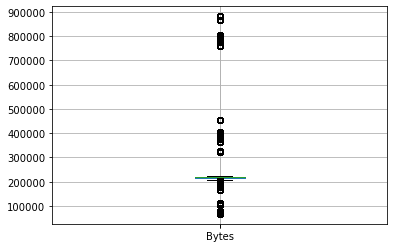

In [5]:
# Получение новых данных
clearedTimeShiftedTrainData = pd.DataFrame(getNewData(clearData(train_data)), columns = ['Bytes', 'Packages'])
clearedTestShiftedTestData = pd.DataFrame(getNewData(clearData(test_data)), columns = ['Bytes', 'Packages'])
print('train data shape', timeShiftedTrainData.shape)
print('test data shape', testShiftedTestData.shape)

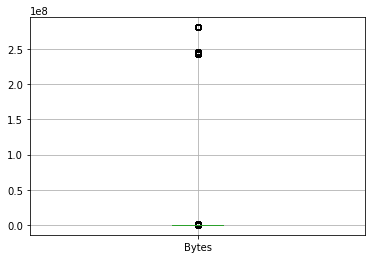

In [8]:
# Проверка разброса данных 
train_data.boxplot(column=['Bytes'])

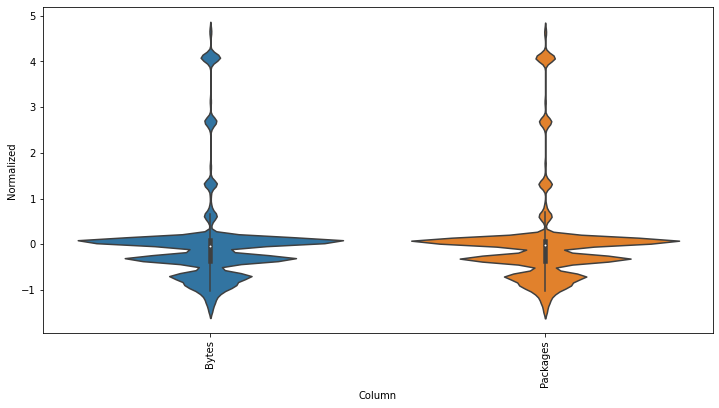

In [9]:
plotNormalized(clearedTimeShiftedTrainData)

In [10]:
clearedTimeShiftedTrainData

,Bytes,Packages
0,110712.00,230.00
1,110712.00,230.00
2,108714.00,225.00
3,54145.25,112.50
4,54145.25,112.50
...,...,...
332709,157094.25,329.25
332710,163141.50,340.50
332711,163141.50,340.50
332712,217522.00,454.00


In [61]:
n = len(clearedTimeShiftedTrainData)
train_df = clearedTimeShiftedTrainData[0:int(n*0.7)]
val_df = clearedTimeShiftedTrainData[int(n*0.7):]

clearedShiftedDataMean = train_df.mean()
clearedShiftedDataStd = train_df.std()


print(clearedShiftedDataMean,'\n',clearedShiftedDataStd)
train_df = normalizeData(train_df, clearedShiftedDataMean,clearedShiftedDataStd)
val_df = normalizeData(val_df, clearedShiftedDataMean, clearedShiftedDataStd)

ENTER_DATA_SIZE = 30
X_train, y_train = generateDataset(train_df, ENTER_DATA_SIZE=ENTER_DATA_SIZE)
X_val, y_val = generateDataset(val_df, ENTER_DATA_SIZE=ENTER_DATA_SIZE)
print(X_train.shape)
print(y_train.shape)

Bytes       208250.691197
Packages       435.958042
dtype: float64 
 Bytes       143913.912763
Packages       299.590957
dtype: float64
(232869, 30, 2)
(232869, 2)


In [12]:
# n = len(normalizedClearedShiftedData)
# train_df = normalizedClearedShiftedData[0:int(n*0.6)]
# val_df = normalizedClearedShiftedData[int(n*0.6):]

# ENTER_DATA_SIZE = 30
# X_train, y_train = generateDataset(train_df, ENTER_DATA_SIZE=ENTER_DATA_SIZE)
# X_val, y_val = generateDataset(val_df, ENTER_DATA_SIZE=ENTER_DATA_SIZE)
# print(X_train.shape)
# print(y_train.shape)

(199598, 30, 2)
(199598, 2)


In [62]:
def compile_and_fit(model, trainX, trainY, validData, patience=10, MAX_EPOCHS = 10):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='auto')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.075),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError(),tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(trainX, trainY, epochs=MAX_EPOCHS,
                      validation_data=validData,
                      callbacks=[early_stopping])
    return history

In [63]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=2),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
#     tf.keras.layers.Reshape([1, -1]),
])


history = compile_and_fit(multi_step_dense, X_train, y_train, (X_val, y_val),MAX_EPOCHS= 50)

Epoch 1/50
7278/7278 [==============================] - 6s 872us/step - loss: 0.3518 - mean_absolute_percentage_error: 521.4432 - root_mean_squared_error: 0.5931 - val_loss: 0.5322 - val_mean_absolute_percentage_error: 524.5208 - val_root_mean_squared_error: 0.7295
Epoch 2/50
7278/7278 [==============================] - 6s 858us/step - loss: 0.3091 - mean_absolute_percentage_error: 495.6576 - root_mean_squared_error: 0.5560 - val_loss: 0.3229 - val_mean_absolute_percentage_error: 277.2891 - val_root_mean_squared_error: 0.5682
Epoch 3/50
7278/7278 [==============================] - 6s 881us/step - loss: 0.2965 - mean_absolute_percentage_error: 492.7876 - root_mean_squared_error: 0.5445 - val_loss: 0.3239 - val_mean_absolute_percentage_error: 439.1564 - val_root_mean_squared_error: 0.5692
Epoch 4/50
7278/7278 [==============================] - 6s 888us/step - loss: 0.2876 - mean_absolute_percentage_error: 485.0318 - root_mean_squared_error: 0.5363 - val_loss: 0.3133 - val_mean_absolute_p

In [64]:
predicted = multi_step_dense.predict(X_train)
evalute =  multi_step_dense.evaluate(X_val, y_val)
evalute

3119/3119 [==============================] - 2s 537us/step - loss: 0.2755 - mean_absolute_percentage_error: 553.4448 - root_mean_squared_error: 0.5249


[0.27547961473464966, 553.4447631835938, 0.5248615145683289]

In [65]:
def plotGraph(xTrain, trueVal, predicted):
    x1 = [x for x in range(0, 93, 3)]

    y1 = np.append(xTrain , trueVal)

    plt.subplot(1, 1, 1)
    plt.plot(x1, y1, 'o-')

    plt.plot(90, predicted, 'go') 
    plt.xlabel('time (s)')
    plt.ylabel('Undamped')

    plt.show()
    
    
def plotGraphWithDots(xTrain, trueVal, predicted):
    x1 = [x for x in range(0, len(xTrain) * 3 + 3, 3)]
    x2 = [x for x in range(0 , len(predicted) * 3, 3)]
    
    y1 = np.append(xTrain , trueVal)
    
    plt.subplot(1, 1, 1)
    plt.plot(x1, y1, 'o-')
    
    plt.plot(x2, predicted, 'go') 
    
    plt.xlabel('time (s)')
    plt.ylabel('Undamped')

    plt.show()

In [90]:
X_test1, y_test1 = generateDataset(clearedTestShiftedTestData, ENTER_DATA_SIZE=ENTER_DATA_SIZE)

In [67]:
#Тестовые данные
normalizedClearedTestShiftedData = normalizeData(clearedTestShiftedTestData, clearedShiftedDataMean,clearedShiftedDataStd)
X_test, y_test = generateDataset(normalizedClearedTestShiftedData, ENTER_DATA_SIZE=ENTER_DATA_SIZE)


In [68]:
multi_step_dense.evaluate(X_test, y_test)
predictTestNumpy = multi_step_dense.predict(X_test)
predictTest = pd.DataFrame(predictTestNumpy, columns = ['Bytes', 'Packages'])
predictTest

8723/8723 [==============================] - 5s 551us/step - loss: 0.4028 - mean_absolute_percentage_error: 255.7117 - root_mean_squared_error: 0.6347


,Bytes,Packages
0,-1.388233,-1.360602
1,-1.388405,-1.361291
2,-1.388807,-1.361841
3,-1.388908,-1.362148
4,-1.379292,-1.353140
...,...,...
279129,-0.716123,-0.705680
279130,-0.594434,-0.584760
279131,-0.383800,-0.383248
279132,-0.287200,-0.289275


In [120]:
predictedUnNormalized = unNormalizedData(predictTest,clearedShiftedDataMean,clearedShiftedDataStd)

y_test_UnNormalized = pd.DataFrame(y_test, columns = ['Bytes', 'Packages'])
y_test_UnNormalized = unNormalizedData(y_test_UnNormalized,clearedShiftedDataMean,clearedShiftedDataStd)

mean_absolute_percentage_error(np.array(y_test_UnNormalized)[:,0], np.array(predictedUnNormalized)[:,0])

106.73112946107489

In [124]:
np.array(y_test_UnNormalized)[:,0]

array([   232.05128205,    232.05128205,    232.05128205, ...,
       159310.5       , 164378.25      , 164378.25      ])

In [105]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

mean_absolute_percentage_error(y_test[:,0], predictTestNumpy[:,0])

169.5506954224329

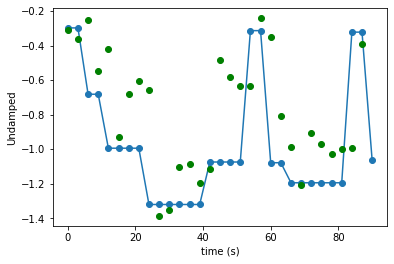

In [112]:
pointIndex=10002
plotGraphWithDots(X_test[pointIndex][:,0],y_test[pointIndex][0],
                  predicted=predictTest.values[pointIndex - ENTER_DATA_SIZE:pointIndex][:,0])

In [113]:
unNormalized = unNormalizedData(predictTest,clearedShiftedDataMean,clearedShiftedDataStd)
unNormalized

,Bytes,Packages
0,8464.638900,28.333945
1,8439.951595,28.127661
2,8382.033360,27.962733
3,8367.468022,27.870877
4,9751.432482,30.569572
...,...,...
279129,105190.587534,224.542835
279130,122703.296459,260.769213
279131,153016.578665,321.140371
279132,166918.554851,349.293799


In [85]:
clearedTestShiftedTestData[2210:]

,Bytes,Packages
2210,28881.391304,60.00
2211,28881.391304,60.00
2212,28881.391304,60.00
2213,28881.391304,60.00
2214,28881.391304,60.00
...,...,...
279159,82655.625000,172.50
279160,159310.500000,335.25
279161,159310.500000,335.25
279162,164378.250000,345.00


In [86]:
unNormalized[2210:]

,Bytes,Packages
2210,115236.038755,247.047367
2211,73428.320100,160.400142
2212,108077.766943,233.188861
2213,103706.621476,223.194594
2214,97715.712621,209.760103
...,...,...
279129,105190.587534,224.542835
279130,122703.296459,260.769213
279131,153016.578665,321.140371
279132,166918.554851,349.293799


In [114]:
unNormalized.to_csv("output_test.csv", sep=';')

In [115]:
unNormalizedData(normalizedClearedTestShiftedData,clearedShiftedDataMean,clearedShiftedDataStd)

,Bytes,Packages
0,34953.666667,72.50
1,34953.666667,72.50
2,34953.666667,72.50
3,34953.666667,72.50
4,34953.666667,72.50
...,...,...
279159,82655.625000,172.50
279160,159310.500000,335.25
279161,159310.500000,335.25
279162,164378.250000,345.00


In [116]:
clearedTestShiftedTestData.to_csv("output.csv",sep=';')

In [117]:
multi_step_dense.save("model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/assets


In [118]:
multi_step_dense.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          multiple                  0         
_________________________________________________________________
dense_18 (Dense)             multiple                  7808      
_________________________________________________________________
dense_19 (Dense)             multiple                  8256      
_________________________________________________________________
dense_20 (Dense)             multiple                  130       
Total params: 16,194
Trainable params: 16,194
Non-trainable params: 0
_________________________________________________________________
